## Import the necessary python modules first

In [54]:
import numpy as np, sys, os, warnings
import matplotlib.cbook
warnings.filterwarnings("ignore", category=DeprecationWarning)

%load_ext autoreload
%autoreload 2

#%pylab notebook
%matplotlib inline
from pylab import *
cmap = cm.RdYlBu_r

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [55]:
rcParams['figure.dpi'] = 150
rcParams["figure.facecolor"] = 'white'

## Some useful functions

In [56]:
def get_lxly(flatskymapparams):

    """
    return lx, ly modes (kx, ky Fourier modes) for a flatsky map grid.
    """
    
    ny, nx, dx = flatskymapparams
    dx = np.radians(dx/60.)

    lx, ly = np.meshgrid( np.fft.fftfreq( nx, dx ), np.fft.fftfreq( ny, dx ) )
    lx *= 2* np.pi
    ly *= 2* np.pi

    return lx, ly

################################################################################################################

def cl_to_cl2d(el, cl, flatskymapparams):
    
    """
    Interpolating a 1d power spectrum (cl) defined on multipoles (el) to 2D assuming azimuthal symmetry (i.e:) isotropy.
    """
    
    lx, ly = get_lxly(flatskymapparams)
    ell = np.sqrt(lx**2. + ly**2.)
    cl2d = np.interp(ell.flatten(), el, cl, left = 0., right = 0.).reshape(ell.shape)
    return cl2d

################################################################################################################

def make_gaussian_realisation(mapparams, el, cl, bl = None):

    """
    create Gaussian realisation of an underlying power spectrum

    input:
    mapparams = [ny, nx, dx] where ny, nx = flatskymap.shape; and dx is the pixel resolution in arcminutes.
    for example: [100, 100, 0.5] is a 50' x 50' flatskymap that has dimensions 100 x 100 with dx = 0.5 arcminutes.

    el: multiple bins over which the input power spectrum cl is defined.
    cl: input power spectrum.
    bl: smoothing function (the telescope beam).

    output:
    simulated Gaussian realisation of the input power spectrum
    """

    ny, nx, dx = mapparams
    arcmins2radians = np.radians(1/60.)

    dx *= arcmins2radians

    ################################################
    #map stuff
    norm = np.sqrt(1./ (dx**2.))
    ################################################

    cltwod = cl_to_cl2d(el, cl, mapparams)

    cltwod = cltwod**0.5 * norm
    cltwod[np.isnan(cltwod)] = 0.

    gauss_reals = np.random.standard_normal([nx,ny])
    #print(gauss_reals[0,0], cl[20:23]); 
    sim = np.fft.ifft2( np.copy( cltwod ) * np.fft.fft2( gauss_reals ) ).real

    #add instrumental beam
    if bl is not None:
        if np.ndim(bl) != 2:
            bl = cl_to_cl2d(el, bl, mapparams)
        sim = np.fft.ifft2( np.fft.fft2(SIM) * bl).real

    #remove mean
    sim = sim - np.mean(sim)

    return sim

################################################################################################################

def map2cl(flatskymapparams, flatskymap1, flatskymap2 = None, lmin = 2, lmax = 12000, binsize = None, mask = None, filter_2d = None):

    """
    map2cl module - get the power spectra of map/maps

    input:
    flatskymyapparams = [ny, nx, dx] where ny, nx = flatskymap.shape; and dx is the pixel resolution in arcminutes.
    for example: [100, 100, 0.5] is a 50' x 50' flatskymap that has dimensions 100 x 100 with dx = 0.5 arcminutes.

    flatskymap1: map1 with dimensions (ny, nx)
    flatskymap2: provide map2 with dimensions (ny, nx) cross-spectra

    binsize: el bins. computed automatically if None

    cross_power: if set, then compute the cross power between flatskymap1 and flatskymap2

    output:
    auto/cross power spectra: [el, cl, cl_err]
    """

    ny, nx, dx = flatskymapparams
    dx_rad = np.radians(dx/60.)

    lx, ly = get_lxly(flatskymapparams)

    if binsize == None:
        binsize = lx.ravel()[1] -lx.ravel()[0]

    if flatskymap2 is None:
        flatskymap_psd = abs( np.fft.fft2(flatskymap1) * dx_rad)** 2 / (nx * ny)
    else: #cross spectra now
        assert flatskymap1.shape == flatskymap2.shape
        flatskymap_psd = np.fft.fft2(flatskymap1) * dx_rad * np.conj( np.fft.fft2(flatskymap2) ) * dx_rad / (nx * ny)

    rad_prf = radial_profile(flatskymap_psd, (lx,ly), bin_size = binsize, minbin = lmin, maxbin = lmax, to_arcmins = 0)
    el, cl = rad_prf[:,0], rad_prf[:,1]

    if mask is not None:
        fsky = np.mean(mask)
        cl /= fsky

    if filter_2d is not None:
        rad_prf_filter_2d = radial_profile(filter_2d, (lx,ly), bin_size = binsize, minbin = lmin, maxbin = lmax, to_arcmins = 0)
        el, fl = rad_prf_filter_2d[:,0], rad_prf_filter_2d[:,1]
        cl /= fl

    return el, cl

################################################################################################################

def radial_profile(z, xy = None, bin_size = 1., minbin = 0., maxbin = 10., to_arcmins = 1):

    """
    get the radial profile of an image (both real and fourier space).
    """

    z = np.asarray(z)
    if xy is None:
        x, y = np.indices(image.shape)
    else:
        x, y = xy

    #radius = np.hypot(X,Y) * 60.
    radius = (x**2. + y**2.) ** 0.5
    if to_arcmins: radius *= 60.

    binarr=np.arange(minbin,maxbin,bin_size)
    radprf=np.zeros((len(binarr),3))

    hit_count=[]

    for b,bin in enumerate(binarr):
        ind=np.where((radius>=bin) & (radius<bin+bin_size))
        radprf[b,0]=(bin+bin_size/2.)
        hits = len(np.where(abs(z[ind])>0.)[0])

        if hits>0:
            radprf[b,1]=np.sum(z[ind])/hits
            radprf[b,2]=np.std(z[ind])
        hit_count.append(hits)

    hit_count=np.asarray(hit_count)
    std_mean=np.sum(radprf[:,2]*hit_count)/np.sum(hit_count)
    errval=std_mean/(hit_count)**0.5
    radprf[:,2]=errval

    return radprf

################################################################################################################

def get_butterworth_filter(els, cutouff, lpf_hpf = 'hpf', degree = 2., axlim = 10000):
    if degree is None or degree == -1.0:
        if lpf_hpf == 'hpf':
            degree = 3.
        elif lpf_hpf == 'lpf':
            degree = 10.

    t2 = ( els / (els-cutouff) ) ** (2 * degree)
    if lpf_hpf == 'hpf':
        t2 = 1./t2
    
    butterworth_filter = 1. / (1 + t2)
    
    return butterworth_filter

################################################################################################################

def get_knox_errors(binned_el, cl11, cl22 = None, cl12 = None, delta_el = 1, mask = None, map_size_in_deg = 10.):

    el_ = np.arange(len(bl))
            
    if mask is not None:
        fsky_val = (map_size_in_deg**2. * np.mean(mask**2) /41253.)
    else:
        fsky_val = (map_size_in_deg**2. /41253.)

    if cl22 is not None and cl12 is not None:
        cl_signal = np.sqrt( (cl12**2. + cl11 * cl22)/2. )
    else:
        cl_signal = cl11

    cl_knox_err = np.sqrt(2./ (2.*binned_el + 1.) / fsky_val / delta_el ) * (cl_signal)

    return cl_knox_err
################################################################################################################

def get_likelihood(data, model, cov):

    """
    function to calculate the likelihood given data, model, error / covariance matrix
    """

    if np.ndim(cov) == 1:
        cov = np.eye(len(cov)) * cov

    cov = np.mat(cov)
    cov_inv = np.linalg.inv(cov)

    '''
    sign, logdetval = np.linalg.slogdet(cov)
    logdetval = logdetval * sign
    '''

    residual = data - model

    logLval =  -0.5 * np.asarray( np.dot(residual.T, np.dot( cov_inv, residual ))).squeeze()

    return logLval

In [57]:
#get params for sim generation
lmax = 12000 #corresponds to arcminute scale features on the sky.
els = np.arange(lmax)
boxsize_arcmins, dx = 600., 1.0 #arcminutes

#get ra, dec or map-pixel grid
nx = int(boxsize_arcmins/dx)
mapparams = [nx, nx, dx, dx]
x1,x2 = -nx/2. * dx, nx/2. * dx

ra_for_grid = np.linspace(x1,x2, nx)/60.
dec_for_grid = np.linspace(x1,x2, nx)/60.
ra_grid, dec_grid = np.meshgrid(ra_for_grid,dec_for_grid)

# now let us assume some underlying correlation fuction (between pixels in our map) or power spectrum

## Two choices:

### 1. Flat spectrum:
* #### Meaning that the power is the same on all scales.
    * #### That implies that there is no clustering between pixels (objects) in the sky.
    * #### No correlation between pixels.

### 2. Red spectrum:
* #### Meaning we will see bright / dark blobs in our map.

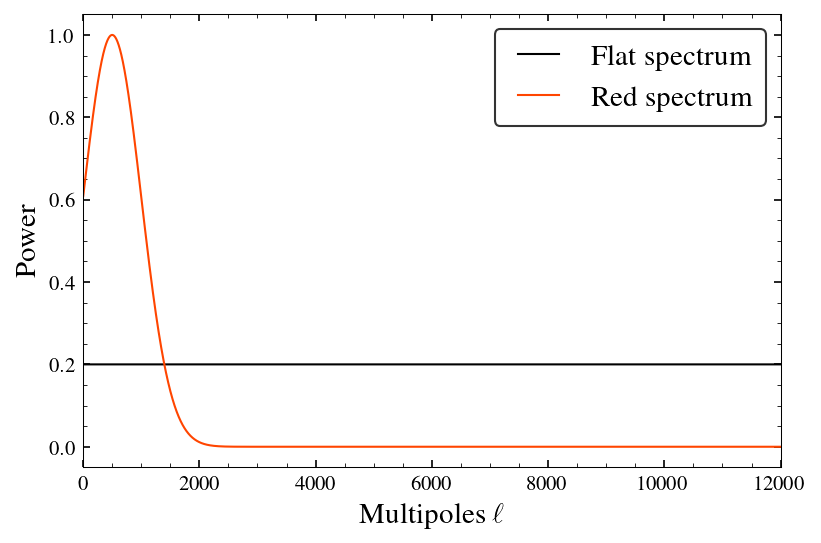

In [82]:
#underlying power spectrum array
els = np.arange(2, lmax)
ang_scale_arr = np.degrees( np.pi/els )
peak_scale = 500.
offset, amp = 0., 5.

#Gaussian beam
fwhm = np.radians(1./60)
sigma = fwhm / np.sqrt(8.0 * np.log(2.0))
gauss_beam = np.exp(-0.5 * els * (els + 1) * sigma**2.)


power_spec_dict = {}

power_spec_dict[0] = offset + np.tile( 1., len(els) ) #flat spectrum
power_spec_dict[1] = offset + amp *np.exp( -(peak_scale - els)**2/ (2*peak_scale**2) ) #Gaussian

power_spec_dict[0] /= max(power_spec_dict[1])
##power_spec_dict[0] /= gauss_beam**2
power_spec_dict[1] /= max(power_spec_dict[1])


#let us now plot these
clf()
fsval = 14
ax = subplot(111)#, yscale = 'log')#, xscale='log') #logrithmic scale is normally preferred when you want to zoom-in into small changes.
plot(els, power_spec_dict[0], color = 'black', label = r'Flat spectrum')
plot(els, power_spec_dict[1], color = 'orangered', label = r'Red spectrum')
legend(loc = 1, fontsize = fsval)
xlabel(r'Multipoles $\ell$', fontsize = fsval)
ylabel(r'Power', fontsize = fsval)
xlim(0., lmax); #ylim(0.1, None)
show()


[0.2 0.2 0.2 ... 0.2 0.2 0.2]


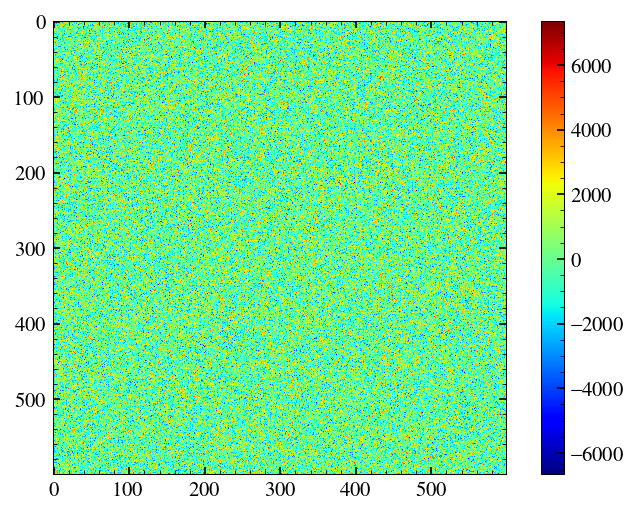

[6.08956769e-001 6.10169800e-001 6.11382801e-001 ... 1.54537669e-115
 1.47591435e-115 1.40956859e-115]


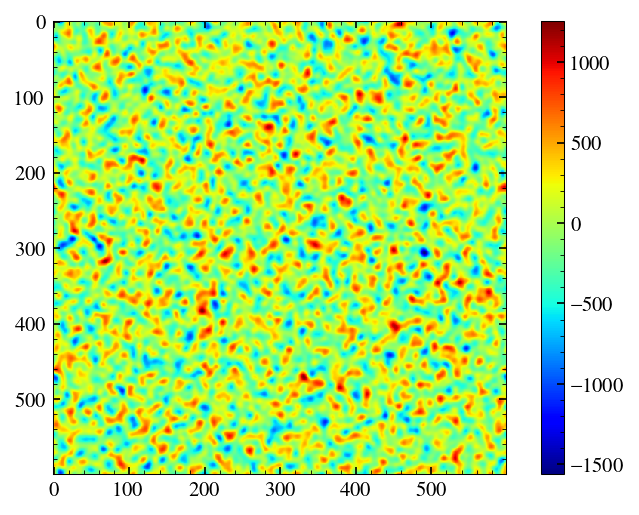

In [83]:
#Let us now create mock maps
mock_map_dict = {}
mapparams = [nx, nx, dx]
for pspec_iter in power_spec_dict:
    print(power_spec_dict[pspec_iter])
    mock_map = make_gaussian_realisation(mapparams, els, power_spec_dict[pspec_iter])
    imshow(mock_map, cmap = cm.jet); colorbar(); show()
    mock_map_dict[pspec_iter] = mock_map


<Figure size 900x600 with 0 Axes>

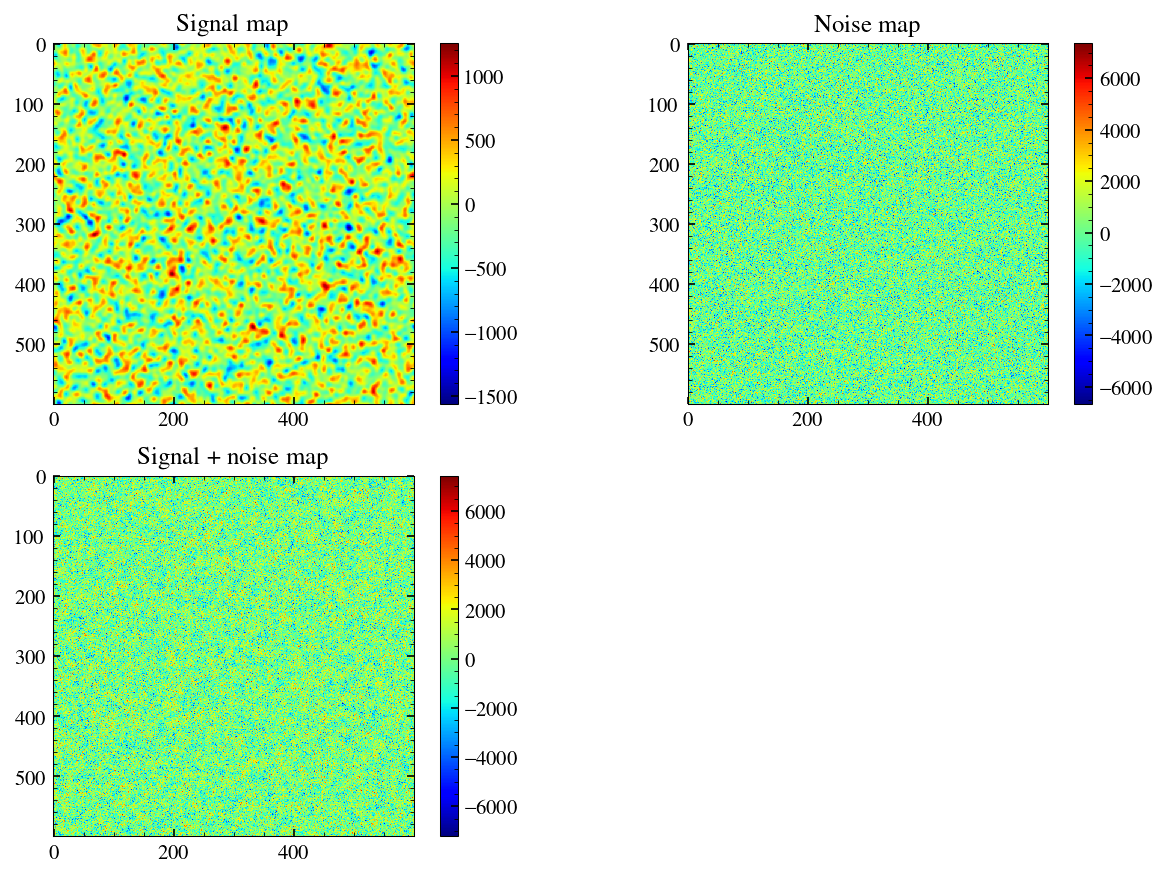

In [89]:
#add noise to the map
white_noise_map = mock_map_dict[0]
signal_map = mock_map_dict[1]
final_mock_map = signal_map + white_noise_map

clf()
figure(figsize = (10., 7.))
subplot(221); imshow( signal_map, cmap = cm.jet ); colorbar(); title(r'Signal map')
subplot(222); imshow( white_noise_map, cmap = cm.jet ); colorbar(); title(r'Noise map')
subplot(223); imshow( final_mock_map, cmap = cm.jet ); colorbar(); title(r'Signal + noise map'); show()

/var/folders/08/mkcy0rls72j2q09krs7qx2jw0000gn/T/ipykernel_51101/2071937801.py:177: RuntimeWarning: divide by zero encountered in true_divide
  t2 = ( els / (els-cutouff) ) ** (2 * degree)


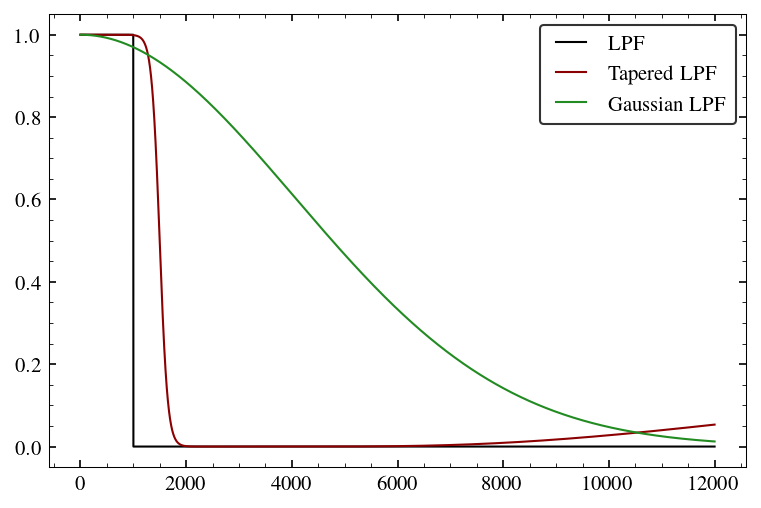

In [94]:
#create some filters
#el_cutoff = 5000.
#el_cutoff = 2000.
el_cutoff = 1000.

#LPF
lpf_1d = np.ones_like( els )
lpf_1d[els>el_cutoff] = 0.

#tapered lpf
lpf_1d_tapered = get_butterworth_filter(els, el_cutoff+2000, lpf_hpf = 'lpf', degree = 5.)

#Gaussian filter
fwhm = np.radians(2./60)
sigma = fwhm / np.sqrt(8.0 * np.log(2.0))
gauss_filter_1d = np.exp(-0.5 * els * (els + 1) * sigma**2.)

plot(els, lpf_1d, label = r'LPF')
plot(els, lpf_1d_tapered, label = r'Tapered LPF')
plot(els, gauss_filter_1d, label = r'Gaussian LPF')
legend(loc = 1)
show()


#2D versions
lpf = cl_to_cl2d(els, lpf_1d, mapparams)
lpf_tapered = cl_to_cl2d(els, lpf_1d_tapered, mapparams)
gauss_filter = cl_to_cl2d(els, gauss_filter_1d, mapparams)

<Figure size 900x600 with 0 Axes>

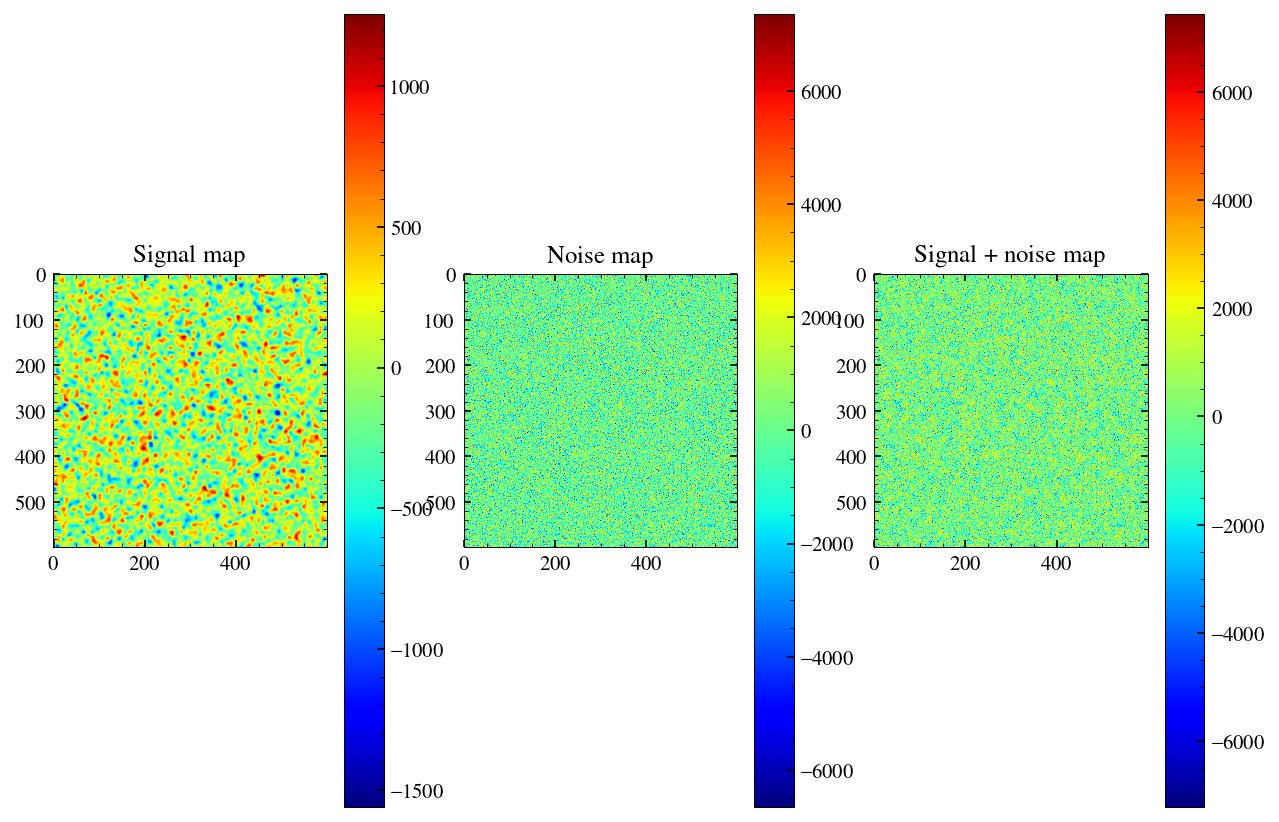

<Figure size 900x600 with 0 Axes>

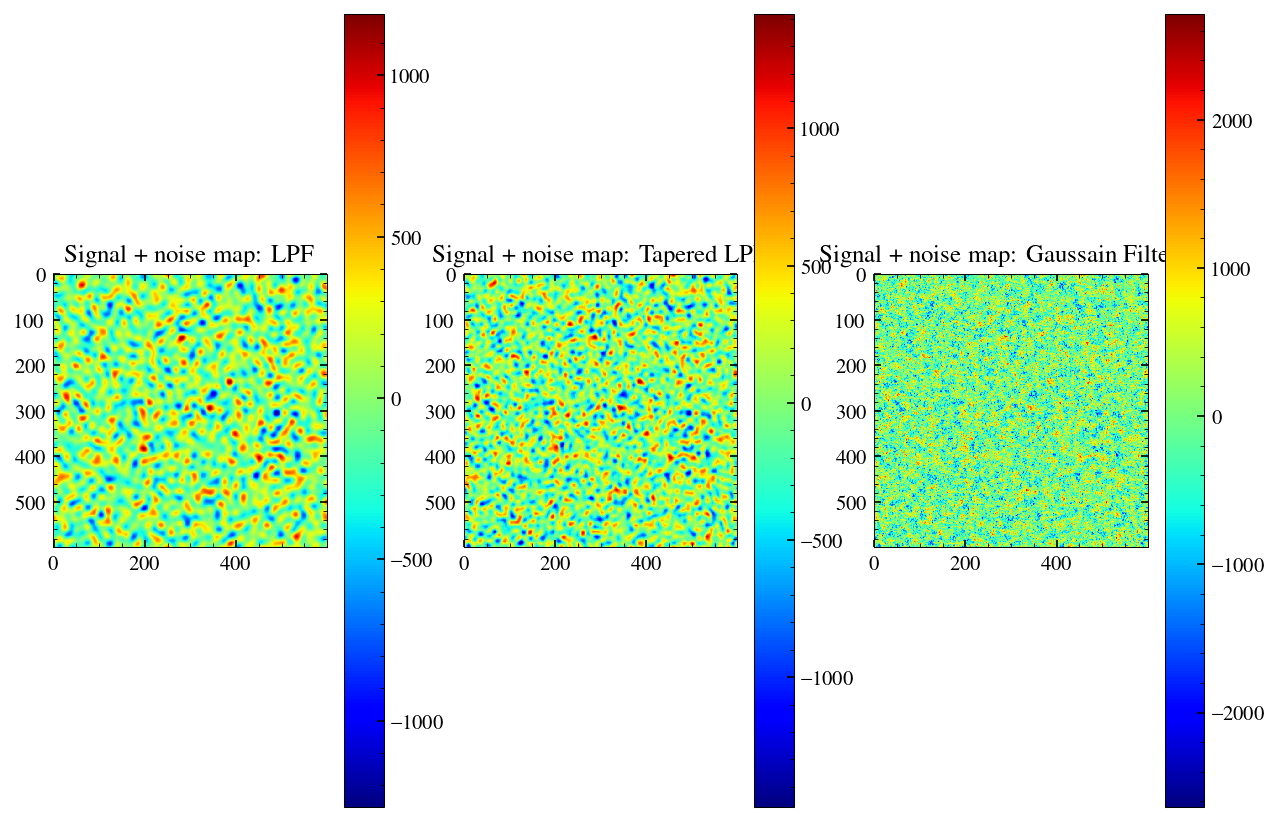

In [95]:
#filter the map with the LPF
final_mock_map_lpf = np.fft.ifft2( np.fft.fft2(final_mock_map) * lpf ).real
final_mock_map_tapered_lpf = np.fft.ifft2( np.fft.fft2(final_mock_map) * lpf_tapered ).real
final_mock_map_gauss_filtered = np.fft.ifft2( np.fft.fft2(final_mock_map) * gauss_filter ).real

clf()
figure(figsize = (10., 7.))
subplot(131); imshow( signal_map, cmap = cm.jet ); colorbar(); title(r'Signal map')
subplot(132); imshow( white_noise_map, cmap = cm.jet ); colorbar(); title(r'Noise map')
subplot(133); imshow( final_mock_map, cmap = cm.jet ); colorbar(); title(r'Signal + noise map')
show()

clf()
figure(figsize = (10., 7.))
subplot(131); imshow( final_mock_map_lpf, cmap = cm.jet ); colorbar(); title(r'Signal + noise map: LPF')
subplot(132); imshow( final_mock_map_tapered_lpf, cmap = cm.jet ); colorbar(); title(r'Signal + noise map: Tapered LPF')
subplot(133); imshow( final_mock_map_gauss_filtered, cmap = cm.jet ); colorbar(); title(r'Signal + noise map: Gaussain Filtered')
show()

In [96]:
#let us now compute the power spectrum of this to make sure the inut statistics are preserved
lmin, lmax, binsize = 10, lmax, 50
binned_el, binned_cl_signal_map = map2cl(mapparams, signal_map, lmin = lmin, lmax = lmax, binsize = binsize)
binned_el, binned_cl_noise_map = map2cl(mapparams, white_noise_map, lmin = lmin, lmax = lmax, binsize = binsize)
binned_el, binned_cl_signal_plus_noise_map = map2cl(mapparams, final_mock_map, lmin = lmin, lmax = lmax, binsize = binsize)

#after filtering
binned_el, binned_cl_signal_plus_noise_map_lpf = map2cl(mapparams, final_mock_map_lpf, lmin = lmin, lmax = lmax, binsize = binsize)
binned_el, binned_cl_signal_plus_noise_map_tapered_lpf = map2cl(mapparams, final_mock_map_tapered_lpf, lmin = lmin, lmax = lmax, binsize = binsize)
binned_el, binned_cl_signal_plus_noise_map_gauss_filtered = map2cl(mapparams, final_mock_map_gauss_filtered, lmin = lmin, lmax = lmax, binsize = binsize)

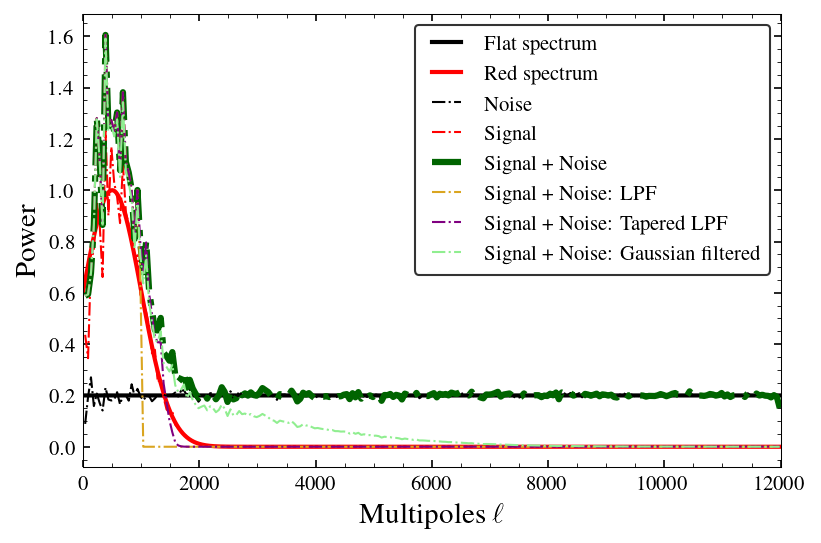

In [97]:
#let us now plot the input and output spectra
clf()
fsval = 14
ax = subplot(111)#, yscale = 'log')#, xscale='log') #logrithmic scale is normally preferred when you want to zoom-in into small changes.

#input spectra
plot(els, power_spec_dict[0], color = 'black', label = r'Flat spectrum', lw = 2.)
plot(els, power_spec_dict[1], color = 'red', label = r'Red spectrum', lw = 2.)

#spectrum of mock maps
plot(binned_el, binned_cl_noise_map, color = 'black', label = r'Noise', ls = '-.')
plot(binned_el, binned_cl_signal_map, color = 'red', label = r'Signal', ls = '-.')
plot(binned_el, binned_cl_signal_plus_noise_map, color = 'darkgreen', label = r'Signal + Noise', ls = '-.', lw = 3.)

#after filtering
plot(binned_el, binned_cl_signal_plus_noise_map_lpf, color = 'goldenrod', label = r'Signal + Noise: LPF', ls = '-.')
plot(binned_el, binned_cl_signal_plus_noise_map_tapered_lpf, color = 'purple', label = r'Signal + Noise: Tapered LPF', ls = '-.')
plot(binned_el, binned_cl_signal_plus_noise_map_gauss_filtered, color = 'lightgreen', label = r'Signal + Noise: Gaussian filtered', ls = '-.')
    

legend(loc = 1, fontsize = 10)
xlabel(r'Multipoles $\ell$', fontsize = fsval)
ylabel(r'Power', fontsize = fsval)
xlim(0., lmax); #ylim(0.1, None)
show()

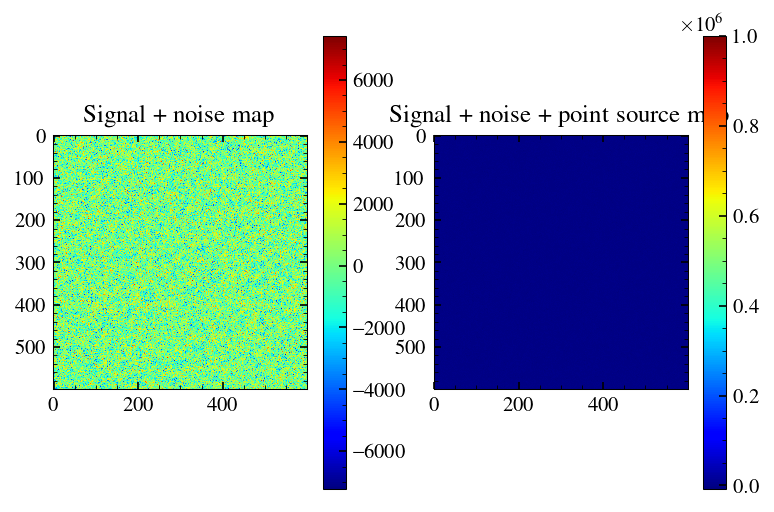

In [98]:
#now let us inject a point source to this maps
final_mock_map_with_point_source = np.copy( final_mock_map )
#final_mock_map_with_point_source = np.copy( signal_map )
ny, nx = final_mock_map_with_point_source.shape
j, i = int(ny/2), int(nx/2)
final_mock_map_with_point_source[j, i] = 1e6
subplot(121); imshow(final_mock_map, cmap = cm.jet); colorbar(); title(r'Signal + noise map')
subplot(122); imshow(final_mock_map_with_point_source, cmap = cm.jet); colorbar(); title(r'Signal + noise + point source map')
show()

<Figure size 900x600 with 0 Axes>

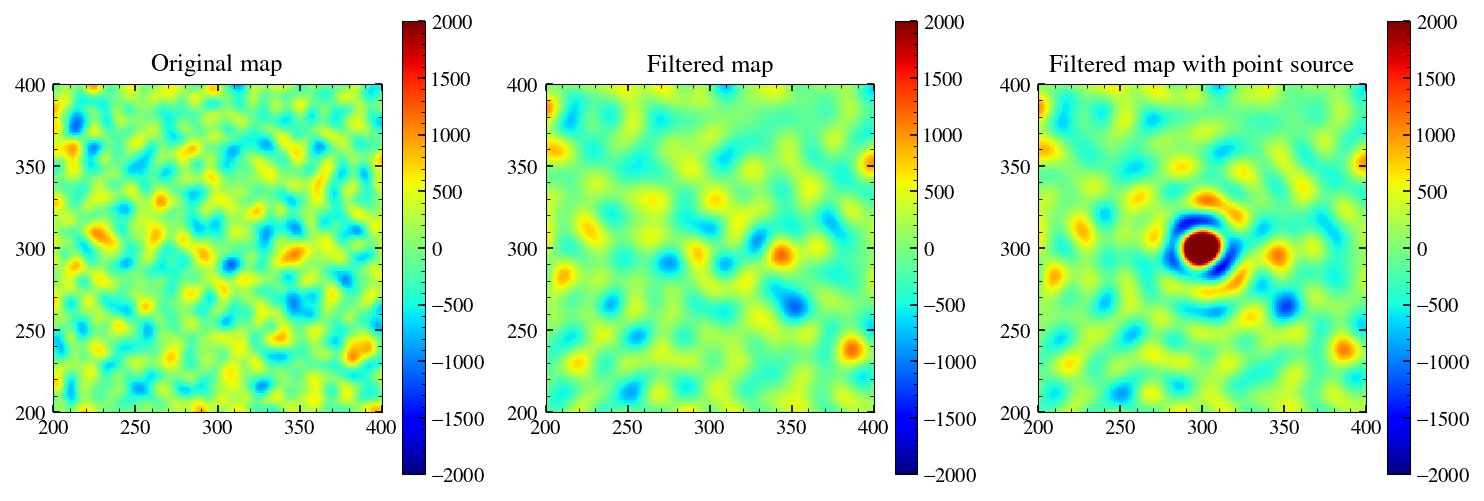

<Figure size 900x600 with 0 Axes>

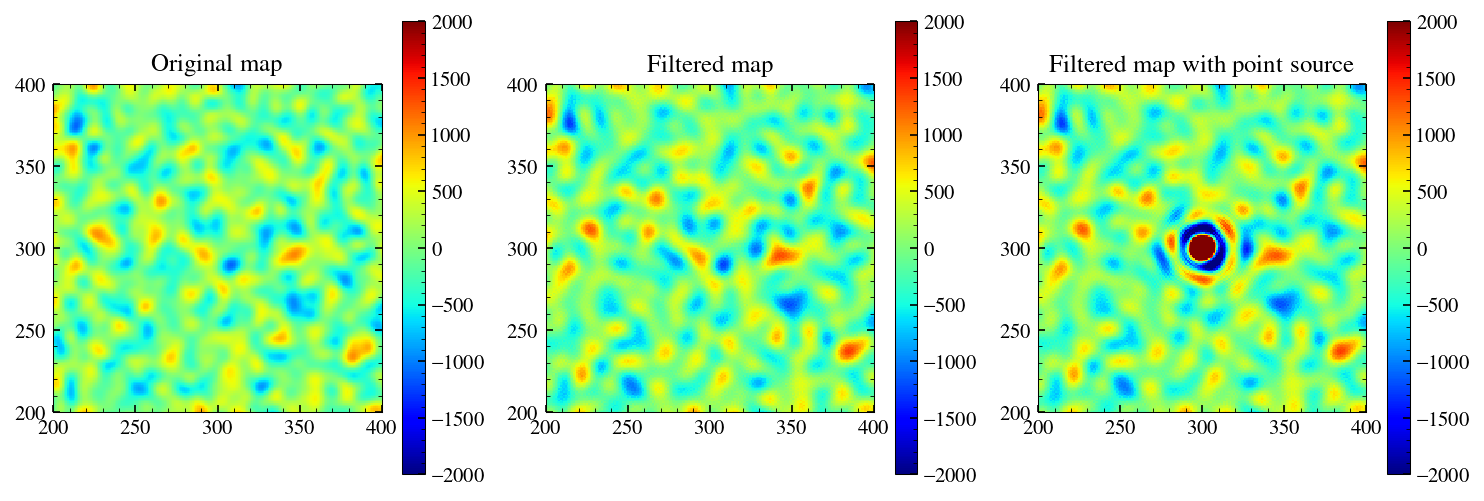

<Figure size 900x600 with 0 Axes>

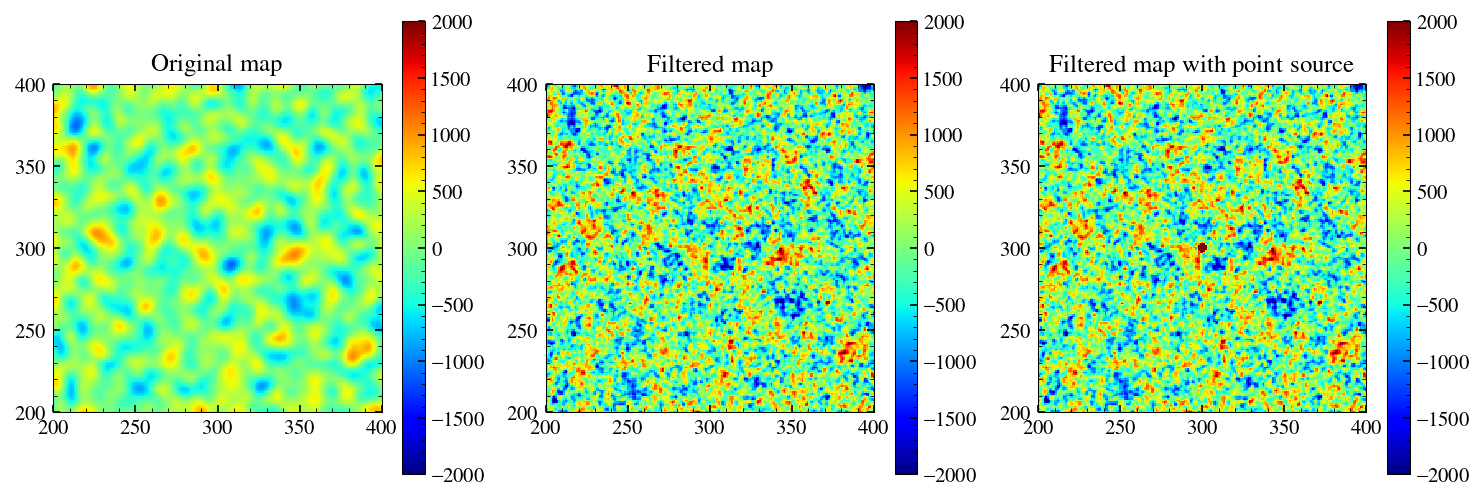

In [104]:
#filter the image now
vmin, vmax = -2000., 2000.
#xmin, xmax = ny/2-50, ny/2+50
xmin, xmax = ny/2-100, ny/2+100
for curr_filter in [lpf, lpf_tapered, gauss_filter]:
    final_mock_map_filtered = np.fft.ifft2( np.fft.fft2(final_mock_map) * curr_filter ).real
    final_mock_map_with_point_source_filtered = np.fft.ifft2( np.fft.fft2(final_mock_map_with_point_source) * curr_filter ).real

    clf()
    figure(figsize = (12, 4.))
    subplot(131); imshow(signal_map, cmap = cm.jet, vmin = vmin, vmax = vmax); colorbar()
    xlim(xmin, xmax); ylim(xmin, xmax); title(r'Original map')
    subplot(132); imshow(final_mock_map_filtered, cmap = cm.jet, vmin = vmin, vmax = vmax); colorbar()
    xlim(xmin, xmax); ylim(xmin, xmax); title(r'Filtered map')
    subplot(133); imshow(final_mock_map_with_point_source_filtered, cmap = cm.jet, vmin = vmin, vmax = vmax); colorbar()
    xlim(xmin, xmax); ylim(xmin, xmax); title(r'Filtered map with point source')
    show()

# Let us now try to do a likelihood analysis: $-2\ {\rm ln}\mathcal{L}(\theta|D) =  \sum_{\ell} \left( D - M \right) \hat{{\bf C}}^{-1}  \left( D - M \right)^{T}$
## For this, we need the following: 
* #### D - Data vector (binned power spectrum)
* #### M - Model vector
* #### $C$ - Covariance matrix


In [105]:
################################################################################################################

def get_knox_errors(binned_el, cl11, cl22 = None, cl12 = None, delta_el = 1, mask = None, map_size_in_deg = 10.):

    if mask is not None:
        fsky_val = (map_size_in_deg**2. * np.mean(mask**2) /41253.)
    else:
        fsky_val = (map_size_in_deg**2. /41253.)
        
    if cl22 is not None and cl12 is not None:
        cl_signal = np.sqrt( (cl12**2. + cl11 * cl22)/2. )
    else:
        cl_signal = cl11

    cl_knox_err = np.sqrt(2./ (2.*binned_el + 1.) / fsky_val / delta_el ) * (cl_signal)

    return cl_knox_err

################################################################################################################

In [107]:
#data vector
binsize = 50
#signal + noise
binned_el, binned_cl_signal_plus_noise_map = map2cl(mapparams, final_mock_map, lmin = lmin, lmax = lmax, binsize = binsize)

#covariance matrix (Error in the power spectrum measurements)
binned_cl_signal_plus_noise_map_err = get_knox_errors(binned_el, binned_cl_signal_plus_noise_map, map_size_in_deg = 10.)


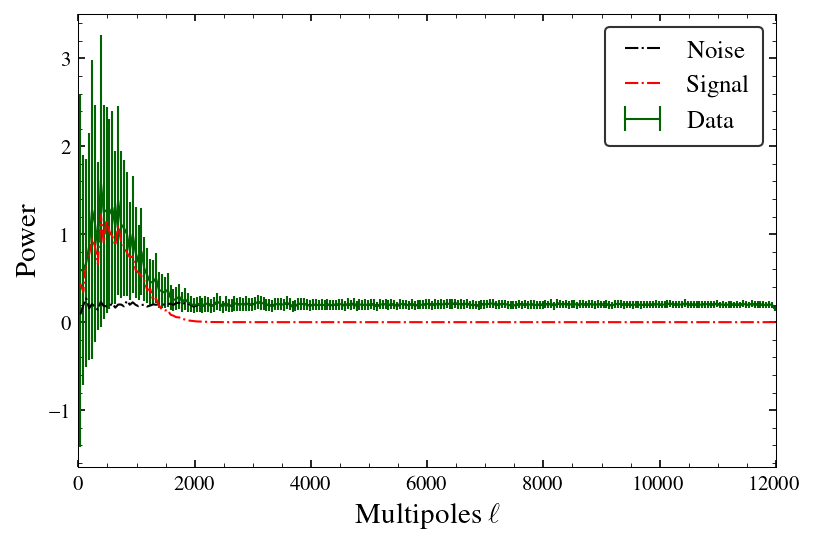

In [108]:
#let us now plot the input and output spectra
clf()
fsval = 14
ax = subplot(111)#, yscale = 'log')#, xscale='log') #logrithmic scale is normally preferred when you want to zoom-in into small changes.

#spectrum of mock maps
plot(binned_el, binned_cl_noise_map, color = 'black', label = r'Noise', ls = '-.')
plot(binned_el, binned_cl_signal_map, color = 'red', label = r'Signal', ls = '-.')

errorbar(binned_el, binned_cl_signal_plus_noise_map, yerr = binned_cl_signal_plus_noise_map_err, color = 'darkgreen', ls = '-', label = r'Data')

legend(loc = 1, fontsize = 12)
xlabel(r'Multipoles $\ell$', fontsize = fsval)
ylabel(r'Power', fontsize = fsval)
xlim(0., lmax); #ylim(0.1, None)
show()

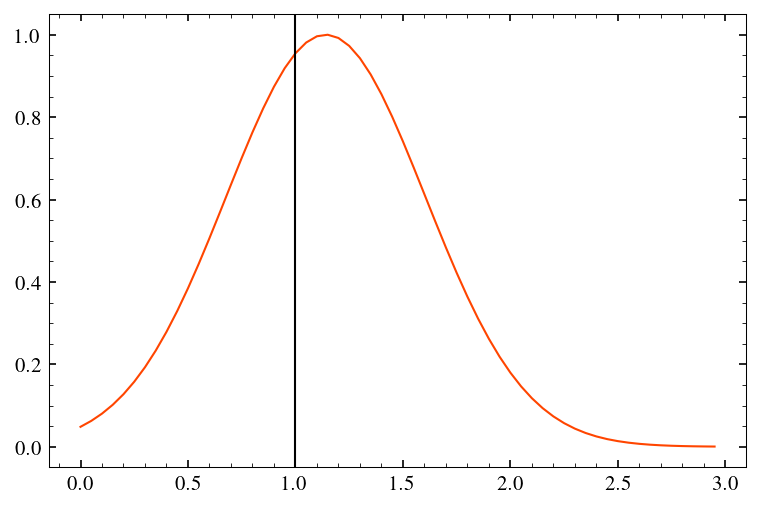

In [117]:
#model
def get_model(amp, els, theory_power_spectrum, binned_el):
    model = amp * theory_power_spectrum
    binned_model = []
    for l1 in binned_el:
        l2 = l1 + binsize
        inds = np.where( (els>l1) & (els<=l2) )[0]
        tmp_model = np.mean(model[inds])
        binned_model.append( tmp_model )

    return np.asarray( binned_model )

def get_likelihood(data, model, cov):

    """
    function to calculate the likelihood given data, model, error / covariance matrix
    """

    if np.ndim(cov) == 1:
        cov = np.eye(len(cov)) * cov

    cov = np.mat(cov)
    cov_inv = np.linalg.inv(cov)

    '''
    sign, logdetval = np.linalg.slogdet(cov)
    logdetval = logdetval * sign
    '''

    residual = np.mat( data - model )
    
    logLval =  -0.5 * np.asarray( np.dot(residual, np.dot( cov_inv, residual.T ))).squeeze()

    return logLval


#range of parameters
amp_arr = np.arange(0., 3., 0.05)

test = False ##True
data = np.copy(binned_cl_signal_plus_noise_map)
error = np.copy(binned_cl_signal_plus_noise_map_err)
underlying_model = power_spec_dict[1]

if test:
    color_arr = [cm.jet(int(d)) for d in np.linspace(0, 255, len(amp_arr))]
    ax = subplot(111)
    plot(els, power_spec_dict[1], color = 'gray', lw = 4.,zorder = 100)
    plot(binned_el, data, color = 'black', lw = 2.,zorder = 100)
    plot(binned_el, error, color = 'hotpink', lw = 2.,zorder = 100)


logL_arr = []
for acntr, amp in enumerate( amp_arr ):
    model = get_model(amp, els, underlying_model, binned_el - binsize/2)

    if (0):
        clf()
        ax = subplot(111)
        plot(els, power_spec_dict[1], color = 'gray', lw = 4.)
        plot(binned_el, model, color = 'black')
        plot(binned_el, data, color = 'red')
        show(); sys.exit()

    if test:
        plot(binned_el, model, lw = 0.2, color = color_arr[acntr])

    if (1):
        cutoff_scale = 500
        inds = np.where( binned_el< cutoff_scale)[0]
        data = data[inds]
        model = model[inds]
        error = error[inds]

    logLval = get_likelihood(data, model, error**2.)

    logL_arr.append( logLval )
logL_arr = logL_arr - max(logL_arr)
Larr = np.exp(logL_arr)
if test:
    show(); sys.exit()

plot( amp_arr, Larr, color = 'orangered' )
#legend(loc = 1)
axvline(1.)
show()


# Load a simulated LSS catalogue

In [124]:
#Agora simulation catalogue
cat = np.load('data/halos_extracted_refined_minM500c0.10.npz', allow_pickle=True)['arr_0']
ra, dec, m500c, z = cat

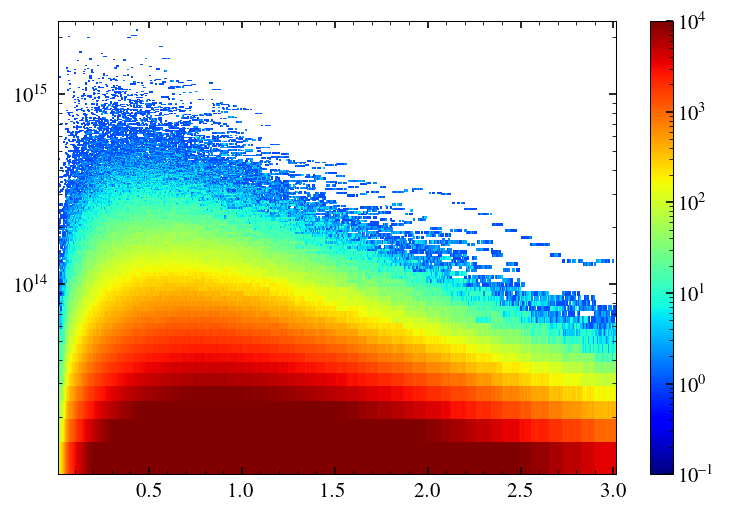

In [125]:
ax = subplot(111, yscale = 'log')
vmin, vmax = .1, 1e4
norm = matplotlib.colors.LogNorm(vmin=vmin, vmax=vmax)
hist2d(z, m500c, bins = 500, norm = norm)
colorbar()
show()

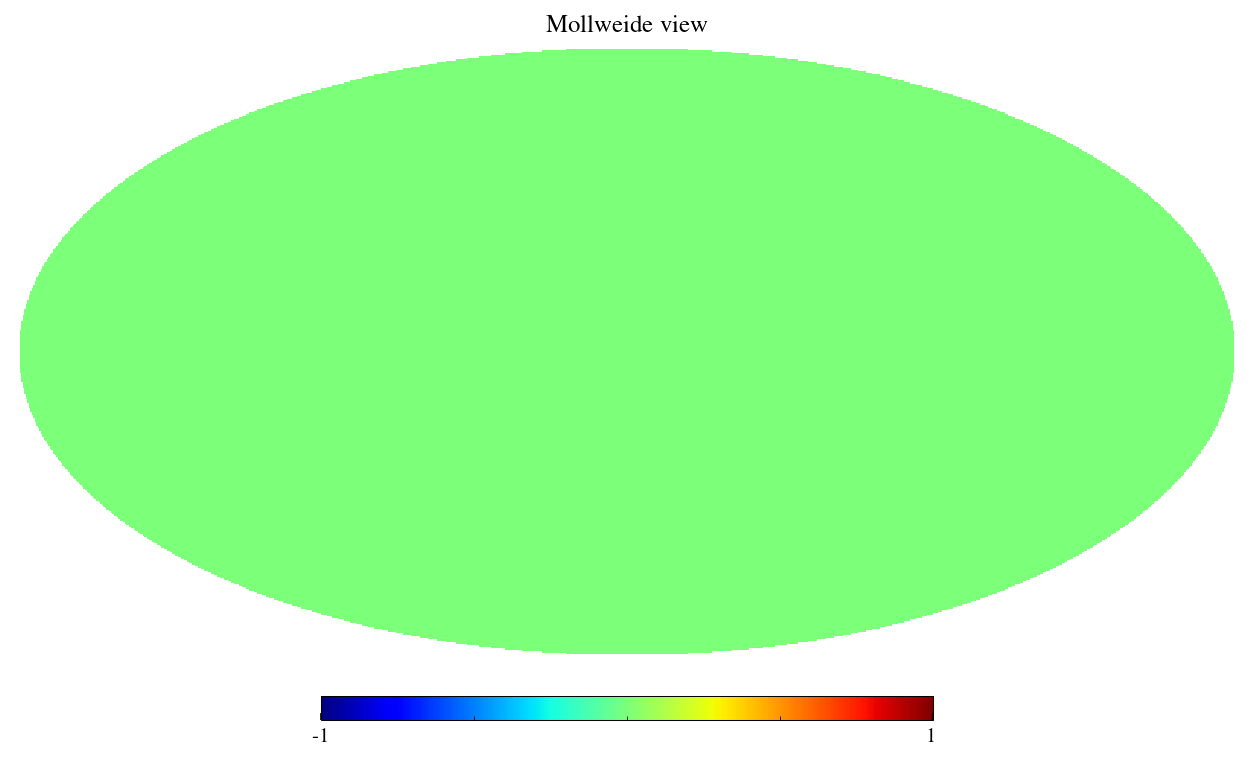

In [126]:
import healpy as H

nside = 256 ##2048
npix = H.nside2npix(nside)

hmap = np.zeros( npix )
H.mollview(hmap); show()

In [127]:
import collections
pixels = H.ang2pix(nside, np.radians(90.-dec), np.radians(ra))
counts = collections.Counter(pixels)
pixinds = np.asarray( list( counts.keys() ) )
pixvals = np.asarray( list( counts.values() ) )
hmap[pixinds] = pixvals

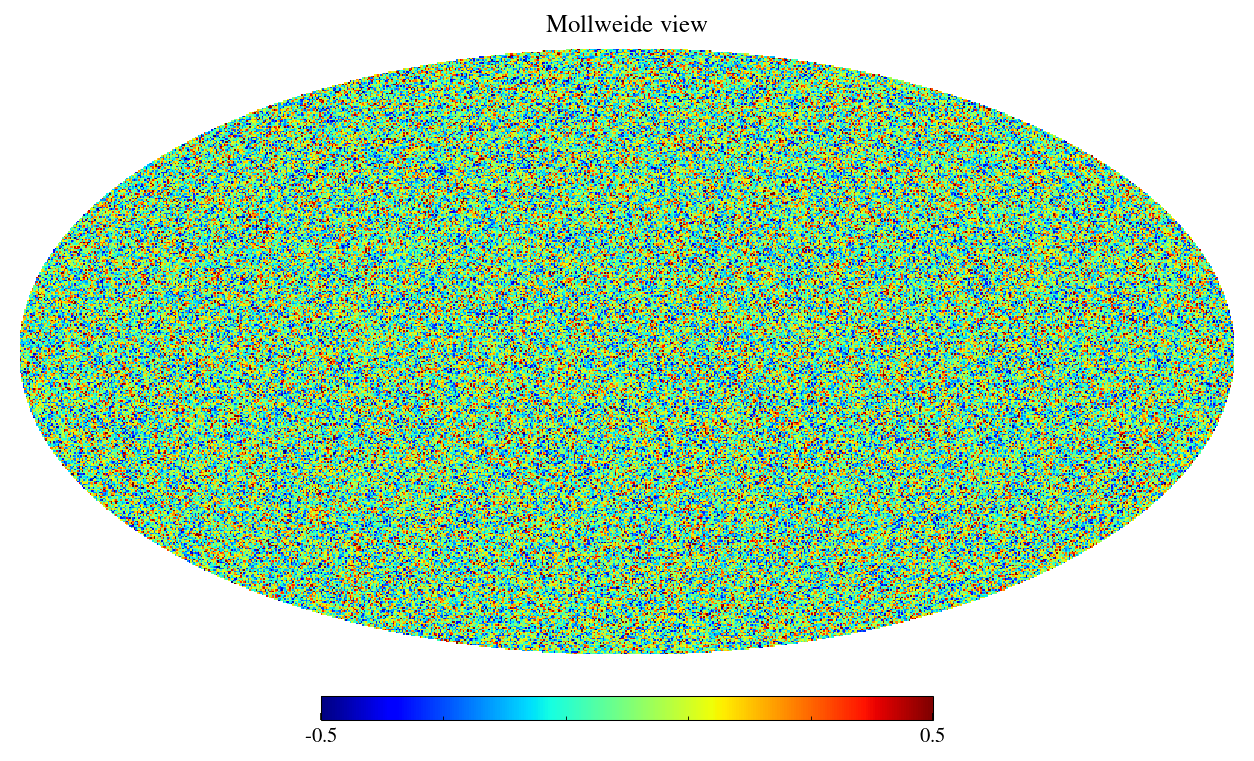

In [128]:
#overdensity
hmap_overdensity = np.copy(hmap)
mean_val = np.mean(hmap[pixinds])
hmap_raw = np.copy(hmap)
hmap_overdensity[pixinds] = (hmap_overdensity[pixinds] - mean_val)/mean_val

H.mollview(hmap_overdensity, min = -0.5, max = 0.5); show()